In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
happy_index = pd.read_csv('2017.csv', sep=',', header=0, names=["country", "rank", 
                                                                "score", "high", "low", "gdp", "family", "health", "free", "gen", "trust","dystopia"])
world_country_names = pd.read_csv('world-country-names.tsv', sep='\t', header=0)

In [3]:
happy_index.head(5)

,country,rank,score,high,low,gdp,family,health,free,gen,trust,dystopia
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


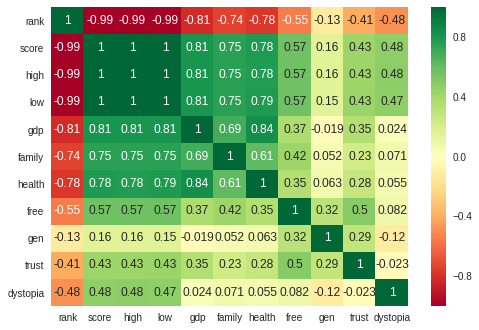

In [4]:
corr_matrix = happy_index.corr()
sns.heatmap(corr_matrix, annot=True, cbar=True, cmap="RdYlGn")
plt.show()

Will be working in the 0 to 1 normalized space

/home/alex/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alex/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2444: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.ix._setitem_with_indexer((slice(None), indexer), value)
/home/alex/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2414: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._seti

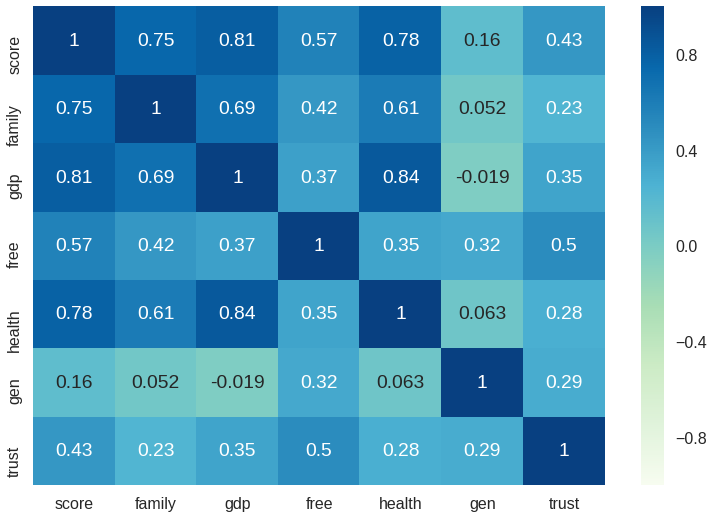

In [5]:
cols = ["score","high", "low", "family", "gdp", "free", "health", "gen", "trust"]
happy_index_simple = happy_index[cols]
scaler = MinMaxScaler()
happy_index_simple[cols] = scaler.fit_transform(happy_index[cols])
corr_matrix = happy_index[["score", "family", "gdp", "free", "health", "gen", "trust"]].corr()
sns.set_context("poster",font_scale=1.0) 
sns.heatmap(corr_matrix, annot=True, cbar=True, cmap="GnBu")
plt.show()

First a simple linear regression fit for each metric

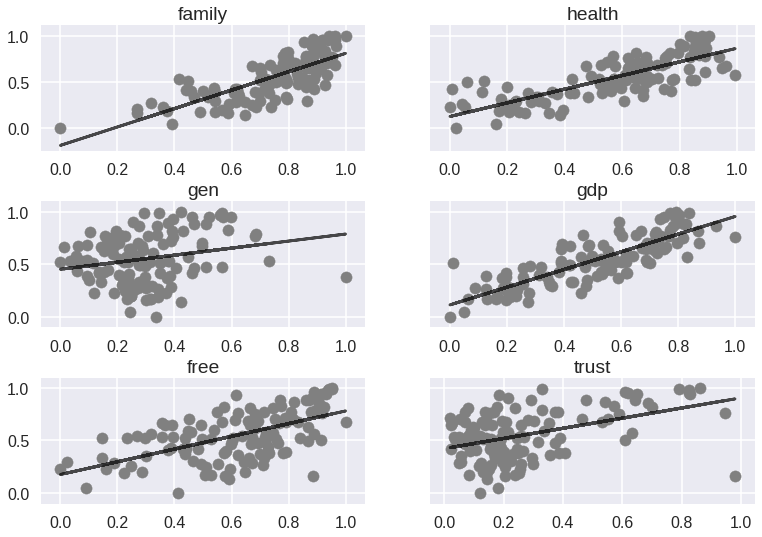

{'family': -0.19111282559627341, 'gdp': 0.11241947769672994, 'free': 0.17566479456088968, 'health': 0.12267774193945741, 'gen': 0.45220622224350115, 'trust': 0.42290508263753834}
{'family': 0.99890174560671718, 'gdp': 0.84325830954672687, 'free': 0.60618096154395307, 'health': 0.7410845960493061, 'gen': 0.3358972416204381, 'trust': 0.48320036676035905}


In [6]:
metrics = ["family", "gdp", "free", "health", "gen", "trust"]
intercepts = {}
coefs = {}
f, axes  = plt.subplots(3, 2, sharey='row')
n = 0 
for metric in metrics:    
    X = happy_index_simple[metric]
    X = X.values.reshape(-1,1)
    y = happy_index_simple["score"]
    y = y.values.reshape(-1,1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)
    lr = LinearRegression(normalize=False, fit_intercept=True)
    lr.fit(X_train,y_train)
    intercepts[metric] = lr.intercept_[0]
    coefs[metric] = lr.coef_[0][0]
    predictions = lr.predict(X_test)
    axes[n%3][n%2].scatter(X_train,y_train, color = "grey")
    #axes[n%3][n%2].scatter(X_test,y_test, color = "black")
    axes[n%3][n%2].plot(X_train, lr.coef_[0][0]*X_train+ lr.intercept_[0], color="black", alpha=.7)
    axes[n%3][n%2].set_title(metric)
    n += 1
f.subplots_adjust(hspace=0.4)
plt.show()
print(intercepts)
print(coefs)

Write out data to a .json format ready for visualization with d3.

In [7]:
coef_vals = [x for x in coefs.values()]
intercept_vals = [x for x in intercepts.values()]
trend1 = {}
trend2 = {}
x0 = .03
x2 = .99 
for n in range(len(metrics)):
    coords1 = {}
    coords2 = {}
    #x2 = max(happy_index[metrics[n]].values) 
    coords1["x"] = x0 
    coords1["y"] = x0 * coef_vals[n] + intercept_vals[n]
    trend1[metrics[n]] = coords1 #.1 * coef_vals[n] + intercept_vals[n]
    coords2["x"] = x2
    coords2["y"] = x2 * coef_vals[n] + intercept_vals[n] 
    trend2[metrics[n]] = coords2
fit_string = "[" + str(trend1).replace("\'","\"") + "," + str(trend2).replace("\'","\"") +  "]"
f = open('linear_trend.json', 'w')
f.write(fit_string)
f.close()

In [8]:
def plot_errors(X_test,y_test,predictions):
    f, axes  = plt.subplots(3, 2, sharey='row')
    n = 0 
    for metric in metrics:
    #axes[n%3][n%2].scatter(X_test[metric].values, y_test, color = "black")
        axes[n%3][n%2].scatter(X_test[metric].values, y_test-predictions, color = "grey", alpha=.7)
        axes[n%3][n%2].set_title(metric)
        n += 1
        f.subplots_adjust(hspace=0.4)
    plt.show()

In [9]:
X = happy_index_simple[metrics]
y = happy_index_simple["score"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

multiple linear regression

Coeff: [ 0.32129958  0.37265724  0.21590507  0.20867665  0.10878386  0.07268908]
Intercept: -0.188321245838
mae: 0.0945516033809
mse: 0.0148954592679
rmse: 0.122046955177
score: 0.696722823515


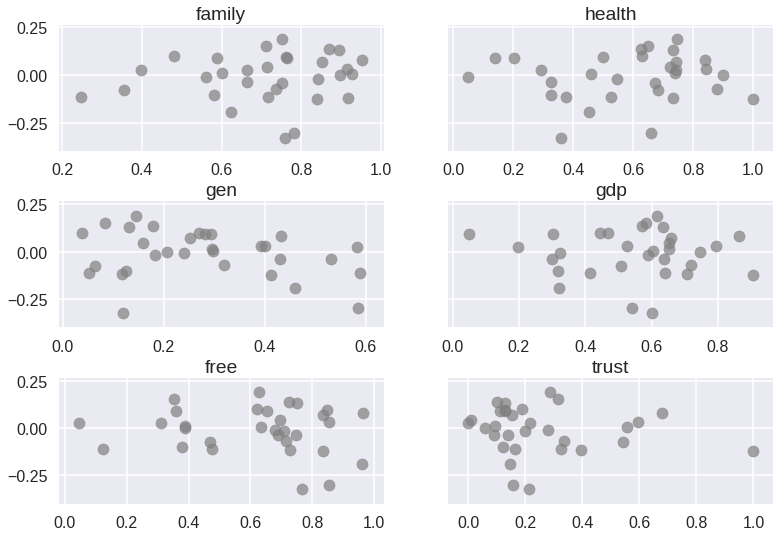

In [10]:
mlr = LinearRegression(normalize=False, fit_intercept=True)
mlr.fit(X_train, y_train)
print('Coeff:', mlr.coef_)
print('Intercept:', mlr.intercept_)
mlr_predictions = mlr.predict(X_test)
print('mae:', mean_absolute_error(y_test, mlr_predictions))
print('mse:', mean_squared_error(y_test, mlr_predictions))
print('rmse:', np.sqrt(mean_squared_error(y_test, mlr_predictions)))
print('score:', mlr.score(X_test, y_test))
plot_errors(X_test, y_test, mlr_predictions)


Gradient Boosting Regressor approach with cross validation and grid search to get best params

mae: 0.0858069790996
mse: 0.0137100881553
rmse: 0.117090085641
score: 0.720857427063


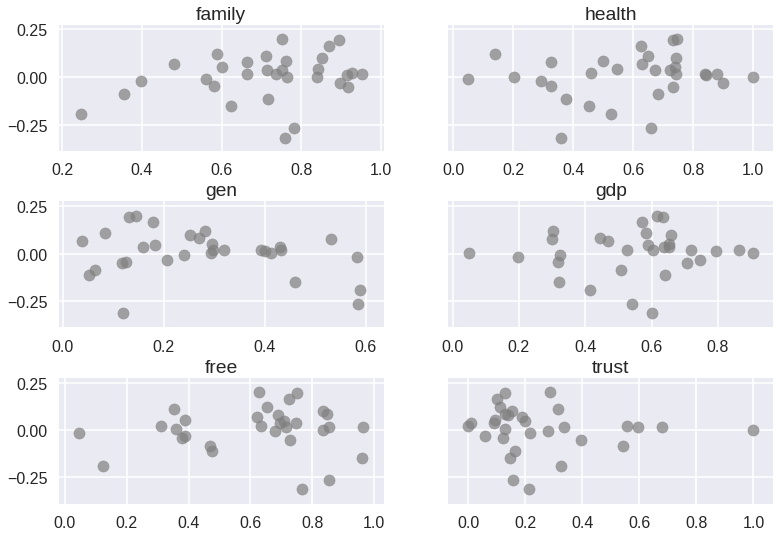

In [11]:
gbr = GradientBoostingRegressor(alpha=0.85, learning_rate=0.1, loss="ls",
                                              max_features=0.9, min_samples_leaf=5,
                                              min_samples_split=6)
param_grid = [
    {'n_estimators': [96,128,512],
    'min_impurity_split': [1e-08,1e-06,1e-05],
    'min_samples_leaf':[1,5],
    'alpha': [.85,.9, .95],
    'max_features': [.5,0.9,1],
    'min_samples_split': [2,6]}
    ]
gbr_grid = GridSearchCV(gbr, cv=2, n_jobs=2, param_grid=param_grid, scoring="neg_mean_squared_error")
gbr_grid.fit(X,y)
gbr_cv = gbr_grid.best_estimator_
#print(gbr_cv.get_params)
gbr_cv.fit(X_train,y_train)
gbr_predictions = gbr_cv.predict(X_test)
print('mae:', mean_absolute_error(y_test, gbr_predictions))
print('mse:', mean_squared_error(y_test, gbr_predictions))
print('rmse:', np.sqrt(mean_squared_error(y_test, gbr_predictions)))
print('score:', gbr_cv.score(X_test, y_test))
plot_errors(X_test, y_test, gbr_predictions)

random forest approach with cross validation and grid search to get best params

mae: 0.0656130705467
mse: 0.00707678081231
rmse: 0.0841236043706
score: 0.855914069868


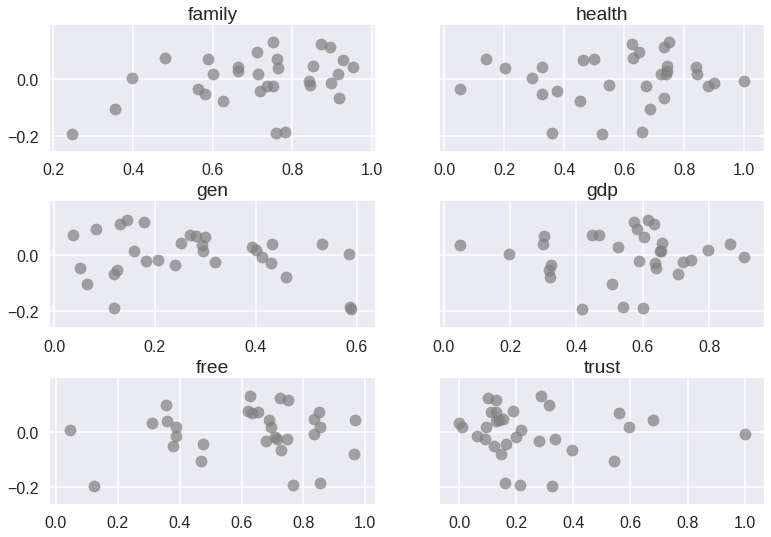

In [12]:
rfr = RandomForestRegressor()
rfr_grid = [
    {'n_estimators': [96,128,512],
    'min_impurity_split': [1e-08,1e-06,1e-05],
    'min_samples_leaf': [1,2,3,4,5],
    'min_samples_split': [2,3,4,5]}
    ]
rfr_grid = GridSearchCV(rfr, cv=2, n_jobs=2, param_grid=rfr_grid, scoring="neg_mean_squared_error")
rfr_grid.fit(X,y)
rfr_cv = rfr_grid.best_estimator_
rfr_predictions = rfr_cv.predict(X_test)
print('mae:', mean_absolute_error(y_test, rfr_predictions))
print('mse:', mean_squared_error(y_test, rfr_predictions))
print('rmse:', np.sqrt(mean_squared_error(y_test, rfr_predictions)))
print('score:', rfr_cv.score(X_test, y_test))
plot_errors(X_test, y_test, rfr_predictions)

Compare all the errors.

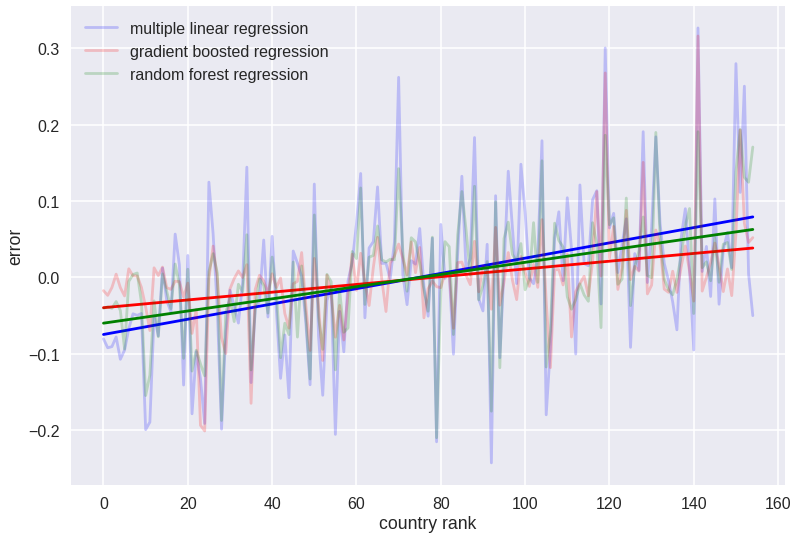

In [13]:
X = happy_index_simple[metrics] 
y = happy_index_simple["score"]
xrange_vals = range(len(X))
xrange_vals = np.asarray(xrange_vals).reshape(-1,1)

#multiple linear regression
mlr_error = - y + mlr.predict(X)
plt.plot(xrange_vals, mlr_error, color="blue", alpha=.2, label='multiple linear regression')
mlr_meta = LinearRegression(normalize=False, fit_intercept=True)
mlr_meta.fit(xrange_vals, mlr_error)
plt.plot(xrange_vals,mlr_meta.predict(xrange_vals), color="blue")

#gradient boosted regression
gbr_error = - y + gbr_cv.predict(X)
plt.plot(xrange_vals, gbr_error, color="red", alpha=.2, label='gradient boosted regression')
gbr_meta = LinearRegression(normalize=False, fit_intercept=True)
gbr_meta.fit(xrange_vals, gbr_error)
plt.plot(xrange_vals, gbr_meta.predict(xrange_vals), color="red")

#random forest regressor
rfr_error = - y + rfr_cv.predict(X)
plt.plot(xrange_vals, rfr_error, color="green", alpha=.2, label='random forest regression')
rfr_meta = LinearRegression(normalize=False, fit_intercept=True)
rfr_meta.fit(xrange_vals, rfr_error)
plt.plot(xrange_vals, rfr_meta.predict(xrange_vals), color="green")


plt.xlabel("country rank")
plt.ylabel("error")
plt.legend()
plt.show()

gradient boosted regression comparison to mean errors

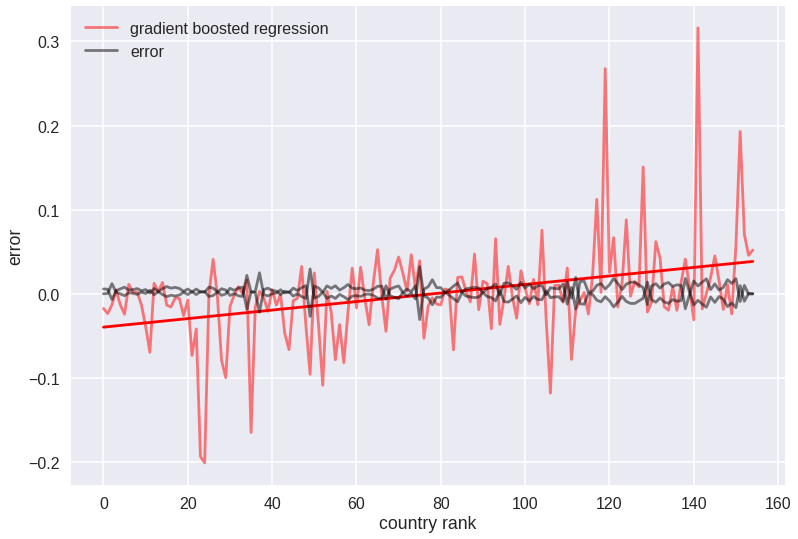

      score      high       low    family       gdp      free    health  \
0  1.000000  0.994201  1.000000  0.952160  0.864065  0.965323  0.839045   
1  0.996903  0.991528  0.996514  0.963086  0.792394  0.951019  0.834726   
2  0.993187  1.000000  0.981126  1.000000  0.791458  0.952775  0.877892   
3  0.991123  0.987333  0.989245  0.941845  0.836545  0.942001  0.903779   
4  0.985962  0.980138  0.986065  0.956334  0.771648  0.938780  0.852200   

        gen     trust     delta      pred  
0  0.431957  0.680505 -0.017331  0.982669  
1  0.423924  0.863156 -0.023476  0.973427  
2  0.567420  0.330657 -0.013219  0.979969  
3  0.346686  0.790440  0.004269  0.995392  
4  0.292913  0.824047 -0.013376  0.972586  


/home/alex/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alex/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
gbr_error = - y + gbr_cv.predict(X)
plt.plot(xrange_vals, gbr_error, color="red", alpha=.5, label='gradient boosted regression')
gbr_meta = LinearRegression(normalize=False, fit_intercept=True)
gbr_meta.fit(xrange_vals, gbr_error)
plt.plot(xrange_vals, gbr_meta.predict(xrange_vals), color="red")
plt.plot(xrange_vals, happy_index_simple["score"]-happy_index_simple["high"], color="black", alpha=.5, label="error")
plt.plot(xrange_vals, happy_index_simple["score"]-happy_index_simple["low"], color="black", alpha=.5)
plt.xlabel("country rank")
plt.ylabel("error")
plt.legend()
plt.show()

happy_index_simple["delta"] = gbr_error
happy_index_simple["pred"] = gbr_cv.predict(X)
print(happy_index_simple.head(5))

the data in the origonal space

In [15]:
invs = (max(happy_index['score']) - min(happy_index['score']))
gbr_error_scaled = - happy_index["score"] + (gbr_cv.predict(X)*invs + min(happy_index['score']))
happy_index["delta"] = gbr_error_scaled 
happy_index["pred"] = gbr_cv.predict(X) * invs + min(happy_index['score'])
print(happy_index.head(5))


       country  rank  score      high       low       gdp    family    health  \
0       Norway     1  7.537  7.594445  7.479556  1.616463  1.533524  0.796667   
1      Denmark     2  7.522  7.581728  7.462272  1.482383  1.551122  0.792566   
2      Iceland     3  7.504  7.622030  7.385970  1.480633  1.610574  0.833552   
3  Switzerland     4  7.494  7.561772  7.426227  1.564980  1.516912  0.858131   
4      Finland     5  7.469  7.527542  7.410458  1.443572  1.540247  0.809158   

       free       gen     trust  dystopia     delta      pred  
0  0.635423  0.362012  0.315964  2.277027 -0.083953  7.453047  
1  0.626007  0.355280  0.400770  2.313707 -0.113719  7.408281  
2  0.627163  0.475540  0.153527  2.322715 -0.064031  7.439970  
3  0.620071  0.290549  0.367007  2.276716  0.020677  7.514677  
4  0.617951  0.245483  0.382612  2.430182 -0.064794  7.404206  


In [16]:
print(np.std(happy_index["high"]-happy_index["score"]))
print(np.std(happy_index["score"]-happy_index["low"]))
print(np.std(gbr_error_scaled))

0.03773075213783981
0.03773075213783895
0.28620772177235443


* All these regression fits under predict the happiness of the most happy countries, whie over predicting the happiness for unhappy countries! But the skew is worst for linear regression.
* Multiple linear regression is simpler to understand so it would be my first choice. For my data visualization I would like to state whether the happy index score is about correct, lower, or higher than expected than the prediction. 

Write the final output csv file for visualization.

In [17]:
happy_index_simple["rank"] = happy_index["rank"]
happy_index_simple["country"] = happy_index["country"]
happy_index_simple.to_csv("2017_pred.csv", index=False, columns=["country", "rank", "score", "gdp", "family", "health", "free", "gen", "trust","pred"])

/home/alex/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/alex/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
